<a href="https://colab.research.google.com/github/yossymaynaldi/EmployeeAttritionAnalysis/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee Attrition Analysis using Machine Learning


Data Source : https://www.kaggle.com/datasets/dianaddx/employee-data-analysis?select=employee_survey_data.csv

## Environment Setting

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    KFold,
    StratifiedShuffleSplit,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score
)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def check (df):
  summary=[]
  for col in df.columns:
    instances = df[col].count()
    dtypes = df[col].dtype
    unique = df[col].nunique()
    sum_null = df[col].isnull().sum()
    duplicates = df[col].duplicated().sum()
    summary.append([col,
                    dtypes,
                    instances,
                    unique,
                    sum_null,
                    duplicates])
  df_check = pd.DataFrame(summary, columns =["column",
                                             "dtype",
                                             "instances",
                                             "unique",
                                             "sum_null",
                                             "duplicates"])
  return df_check

## Data Loading

In [ ]:
general = pd.read_csv('/content/drive/MyDrive/Dataset Kaggle/general_data.csv')
employee = pd.read_csv('/content/drive/MyDrive/Dataset Kaggle/employee_survey_data.csv')
manager = pd.read_csv('/content/drive/MyDrive/Dataset Kaggle/manager_survey_data.csv')

df = pd.merge(general,
              employee,
              on='EmployeeID',
              how='inner')
df=pd.merge(df,
            manager,
            on='EmployeeID',
            how='inner')

print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Dataset contains 4410 rows and 29 columns


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [ ]:
df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Age,4410.0,36.924,9.133,18.0,30.00,36.0,43.00,60.0
DistanceFromHome,4410.0,9.193,8.105,1.0,2.00,7.0,14.00,29.0
Education,4410.0,2.913,1.024,1.0,2.00,3.0,4.00,5.0
EmployeeCount,4410.0,1.000,0.000,1.0,1.00,1.0,1.00,1.0
EmployeeID,4410.0,2205.500,1273.202,1.0,1103.25,2205.5,3307.75,4410.0
JobLevel,4410.0,2.064,1.107,1.0,1.00,2.0,3.00,5.0
MonthlyIncome,4410.0,65029.313,47068.889,10090.0,29110.00,49190.0,83800.00,199990.0
NumCompaniesWorked,4391.0,2.695,2.499,0.0,1.00,2.0,4.00,9.0
PercentSalaryHike,4410.0,15.210,3.659,11.0,12.00,14.0,18.00,25.0
StandardHours,4410.0,8.000,0.000,8.0,8.00,8.0,8.00,8.0


In [ ]:
check(df).sort_values(by="sum_null", ascending=False).reset_index(drop=True)

,column,dtype,instances,unique,sum_null,duplicates
0,WorkLifeBalance,float64,4372,4,38,4405
1,EnvironmentSatisfaction,float64,4385,4,25,4405
2,JobSatisfaction,float64,4390,4,20,4405
3,NumCompaniesWorked,float64,4391,10,19,4399
4,TotalWorkingYears,float64,4401,40,9,4369
5,Over18,object,4410,1,0,4409
6,JobInvolvement,int64,4410,4,0,4406
7,YearsWithCurrManager,int64,4410,18,0,4392
8,YearsSinceLastPromotion,int64,4410,16,0,4394
9,YearsAtCompany,int64,4410,37,0,4373


In [ ]:
df['WorkLifeBalance'].fillna(df['WorkLifeBalance'].median(), inplace=True)
df['EnvironmentSatisfaction'].fillna(df['EnvironmentSatisfaction'].median(), inplace=True)
df['JobSatisfaction'].fillna(df['JobSatisfaction'].median(), inplace=True)
df['NumCompaniesWorked'].fillna(df['NumCompaniesWorked'].median(),inplace=True)
df['TotalWorkingYears'].fillna(df['TotalWorkingYears'].mean(), inplace=True)

In [ ]:
df=df.drop(columns=['EmployeeCount',
                    'Over18',
                    'StandardHours',
                    'EmployeeID'
                    ])
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')

Dataset contains 4410 rows and 25 columns


In [ ]:
check(df).sort_values(by='sum_null',ascending=False).reset_index(drop=True)

,column,dtype,instances,unique,sum_null,duplicates
0,Age,int64,4410,43,0,4367
1,PercentSalaryHike,int64,4410,15,0,4395
2,JobInvolvement,int64,4410,4,0,4406
3,WorkLifeBalance,float64,4410,4,0,4406
4,JobSatisfaction,float64,4410,4,0,4406
5,EnvironmentSatisfaction,float64,4410,4,0,4406
6,YearsWithCurrManager,int64,4410,18,0,4392
7,YearsSinceLastPromotion,int64,4410,16,0,4394
8,YearsAtCompany,int64,4410,37,0,4373
9,TrainingTimesLastYear,int64,4410,7,0,4403


In [ ]:
unique_values={}
for col in df.columns:
  unique_values[col]=df[col].unique()
for key,item in unique_values.items():
  print(f"{key}:{item}\n")

Age:[51 31 32 38 46 28 29 25 45 36 55 47 37 21 35 26 50 53 42 44 49 18 41 39
 58 33 43 52 27 30 54 40 23 48 57 34 24 22 56 60 19 20 59]

Attrition:['No' 'Yes']

BusinessTravel:['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Department:['Sales' 'Research & Development' 'Human Resources']

DistanceFromHome:[ 6 10 17  2  8 11 18  1  7 28 14  3  4 16  9  5 20 29 15 13 24 19 22 25
 21 26 27 12 23]

Education:[2 1 4 5 3]

EducationField:['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']

Gender:['Female' 'Male']

JobLevel:[1 4 3 2 5]

JobRole:['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']

MaritalStatus:['Married' 'Single' 'Divorced']

MonthlyIncome:[131160  41890 193280 ...  37020  23980  54680]

NumCompaniesWorked:[1. 0. 3. 4. 2. 7. 9. 5. 6. 8.]

PercentSalaryHike:[11 23 15 12 13 20 22 21 17 14 16 18 19 24 25]

In [ ]:
df['YearsInCurrentRole'] = df['YearsAtCompany'] - df['YearsSinceLastPromotion']

df['YearsPerCompany'] = df['TotalWorkingYears']/(df['NumCompaniesWorked'].replace(0,1))
df['YearsPerCompany'] = df['YearsPerCompany'].astype(int)

In [ ]:
df['Education_cat'] = df['Education'].apply(lambda x: 'Below College' if x == 1
                                            else ('College' if x == 2
                                                  else ('Bachelor' if x == 3
                                                        else ('Master' if x == 4
                                                              else 'Doctor'))))
df['JobLevel_cat'] = df['JobLevel'].apply(lambda x: 'L1' if x == 1
                                          else ('L2' if x == 2
                                                else ('L3' if x == 3
                                                      else ('L4' if x == 4
                                                            else 'L5'))))
df['StockOptionLevel_cat'] = df['StockOptionLevel'].apply(lambda x: 'L1' if x == 0
                                                          else ('L2' if x == 1
                                                                else ('L3' if x == 2
                                                                      else 'L4')))
df['EnvironmentSatisfaction_cat'] = df['EnvironmentSatisfaction'].apply(lambda x: 'Low' if x == 1
                                                                        else ('Medium' if x == 2
                                                                              else ('High' if x == 3
                                                                                    else 'Very High')))
df['JobSatisfaction_cat'] = df['JobSatisfaction'].apply(lambda x: 'Low' if x == 1
                                                        else ('Medium' if x == 2
                                                              else ('High' if x == 3
                                                                    else 'Very High')))
df['WorkLifeBalance_cat'] = df['WorkLifeBalance'].apply(lambda x: 'Bad' if x == 1
                                                        else ('Good' if x == 2
                                                              else ('Better' if x == 3
                                                                    else 'Best')))
df['JobInvolvement_cat'] = df['JobInvolvement'].apply(lambda x: 'Low' if x == 1
                                                      else ('Medium' if x == 2
                                                            else ('High' if x == 3
                                                                  else 'Very High')))
df['PerformanceRating_cat'] = df['PerformanceRating'].apply(lambda x: 'Excellent' if x== 3
                                                            else 'Outstanding')

In [ ]:
num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

num_variables = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
                 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
                 'YearsInCurrentRole','YearsPerCompany']
cat_variables = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
                 'MaritalStatus', 'Education_cat', 'JobLevel_cat', 'StockOptionLevel_cat',
                 'EnvironmentSatisfaction_cat', 'JobSatisfaction_cat', 'WorkLifeBalance_cat',
                 'JobInvolvement_cat', 'PerformanceRating_cat']

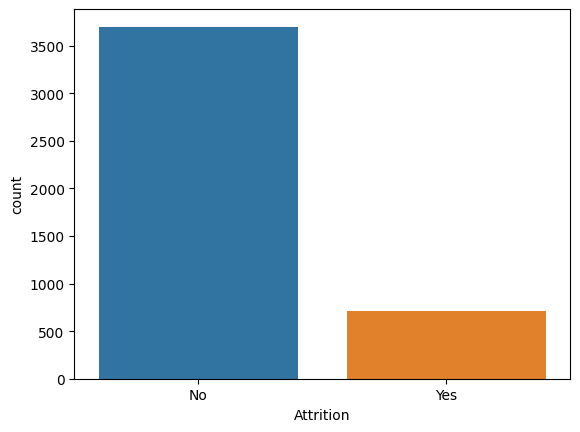

In [ ]:

sns.countplot(x='Attrition', data=df, hue= 'Attrition')
plt.show()

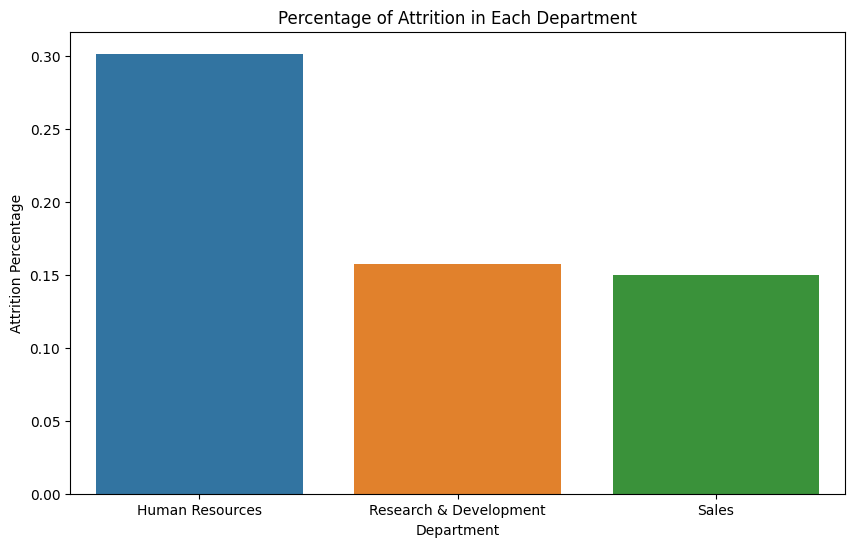

In [ ]:
attrition_percentage = df.groupby('Department')['Attrition'].apply(lambda x : (x=='Yes').mean())

attrition_percentage = attrition_percentage.reset_index()

attrition_percentage.columns =['Department', 'Attrition Percentage']

plt.figure(figsize=(10,6))
sns.barplot(x='Department', y='Attrition Percentage',
            data=attrition_percentage,hue = 'Department')
plt.title('Percentage of Attrition in Each Department')
plt.show()

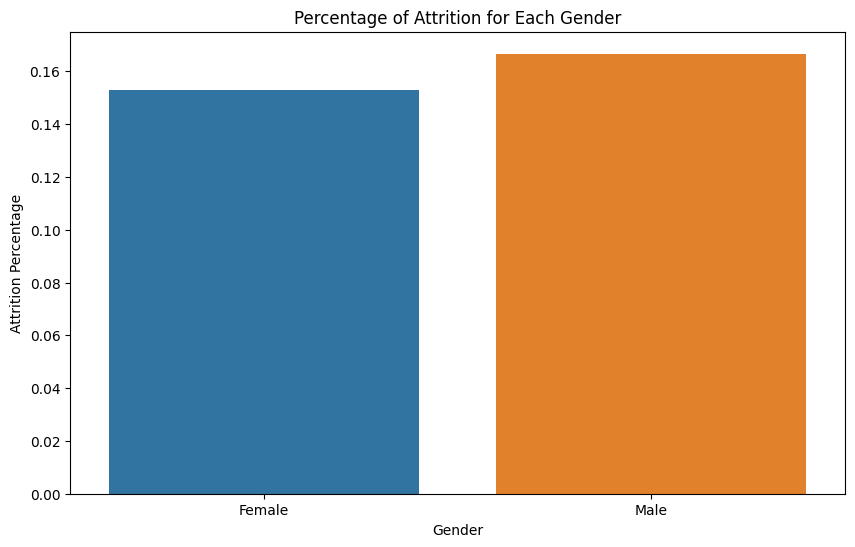

In [ ]:
attrition_percentage_gender = df[df['Attrition'] == 'Yes'].groupby('Gender').size()/df.groupby('Gender').size()

attrition_percentage_gender = attrition_percentage_gender.reset_index()

attrition_percentage_gender.columns = ['Gender',
                                  'Attrition Percentage']

plt.figure(figsize=(10,6))
sns.barplot(x='Gender',
            y='Attrition Percentage',
            data = attrition_percentage_gender,
            hue='Gender')
plt.title('Percentage of Attrition for Each Gender')
plt.show()

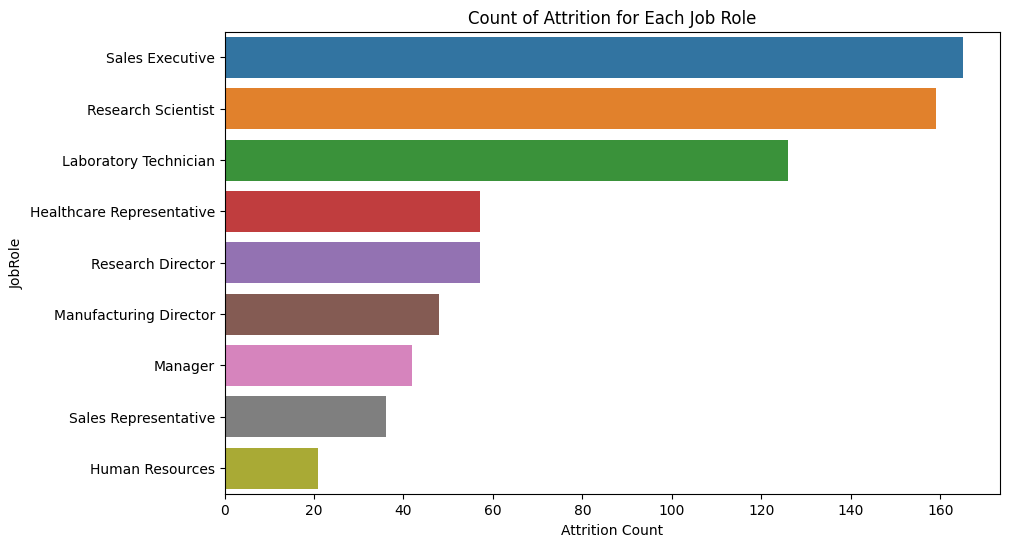

In [ ]:
attrition_count_jobrole = df[df['Attrition']=='Yes']['JobRole'].value_counts()

attrition_count_jobrole = attrition_count_jobrole.reset_index()

attrition_count_jobrole.columns = ['JobRole',
                                   'Attrition Count']

plt.figure(figsize=(10,6))
sns.barplot(x='Attrition Count',
            y='JobRole',
            data =attrition_count_jobrole,
            hue = 'JobRole')
plt.title('Count of Attrition for Each Job Role')
plt.show()

In [ ]:
df.columns.tolist()

['Age',
 'Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'Gender',
 'JobLevel',
 'JobRole',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'JobInvolvement',
 'PerformanceRating',
 'YearsInCurrentRole',
 'YearsPerCompany',
 'Education_cat',
 'JobLevel_cat',
 'StockOptionLevel_cat',
 'EnvironmentSatisfaction_cat',
 'JobSatisfaction_cat',
 'WorkLifeBalance_cat',
 'JobInvolvement_cat',
 'PerformanceRating_cat']

In [ ]:
col_drop = ['Education_cat',
            'JobLevel_cat',
            'StockOptionLevel_cat',
            'EnvironmentSatisfaction_cat',
            'JobSatisfaction_cat',
            'WorkLifeBalance_cat',
            'JobInvolvement_cat',
            'PerformanceRating_cat']
for i in col_drop:
    df.drop(i,axis=1,inplace=True)

In [ ]:
df['Attrition'] = df['Attrition'].apply(lambda x : 1 if x == 'Yes'
                                        else 0)
df['BusinessTravel']=df['BusinessTravel'].apply(lambda x: 0 if x == 'Non-Travel'
                                                else (1 if x == 'Travel_rarely'
                                                      else 2))
df['Department'] = df['Department'].apply(lambda x : 0 if x == 'Sales'
                                          else (1 if x == 'Research & Development'
                                                else 2))
df['EducationField']= df['EducationField'].apply(lambda x:0 if x == 'Life Sciences'
                                                 else (1 if x == 'Other'
                                                       else (2 if x == 'Medical'
                                                             else (3 if x == 'Marketing'
                                                                   else (4 if x == 'Technical Degree'
                                                                         else 5)))))
df['Gender'] = df['Gender'].apply(lambda x: 0 if x == 'Female'
                                  else 1)
df['JobRole']=df['JobRole'].apply(lambda x: 0 if x == 'Healthcare Representative'
                                  else (1 if x == 'Research Scientist'
                                        else (2 if x == 'Sales Executive'
                                              else (3 if x == 'Human Resources'
                                                    else (4 if x == 'Research Director'
                                                          else (5 if x == 'Laboratory Technician'
                                                                else (6 if x == 'Manufacturing Director'
                                                                      else (7 if x == 'Sales Representative'
                                                                      else 8))))))))
df['MaritalStatus']= df['MaritalStatus'].apply(lambda x:0 if x == 'Single'
                                               else (1 if x == 'Maried'
                                                     else 2))


In [ ]:
change_col =['NumCompaniesWorked',
             'TotalWorkingYears',
             'EnvironmentSatisfaction',
             'JobSatisfaction',
             'WorkLifeBalance']
for col in change_col:
  df[col]=df[col].astype(int)

In [ ]:
unique_values={}
for col in df.columns:
  unique_values[col]= df[col].unique()
for key, item in unique_values.items():
  print(f'{key}:{item}\n')

Age:[51 31 32 38 46 28 29 25 45 36 55 47 37 21 35 26 50 53 42 44 49 18 41 39
 58 33 43 52 27 30 54 40 23 48 57 34 24 22 56 60 19 20 59]

Attrition:[0 1]

BusinessTravel:[2 0]

Department:[0 1 2]

DistanceFromHome:[ 6 10 17  2  8 11 18  1  7 28 14  3  4 16  9  5 20 29 15 13 24 19 22 25
 21 26 27 12 23]

Education:[2 1 4 5 3]

EducationField:[0 1 2 3 4 5]

Gender:[0 1]

JobLevel:[1 4 3 2 5]

JobRole:[0 1 2 3 4 5 6 7 8]

MaritalStatus:[2 0]

MonthlyIncome:[131160  41890 193280 ...  37020  23980  54680]

NumCompaniesWorked:[1 0 3 4 2 7 9 5 6 8]

PercentSalaryHike:[11 23 15 12 13 20 22 21 17 14 16 18 19 24 25]

StockOptionLevel:[0 1 3 2]

TotalWorkingYears:[ 1  6  5 13  9 28 10 21 16 37  7  3 15  8 11 12 17 19 22  2  4 23  0 24
 25 20 14 26 18 30 36 31 33 32 34 40 29 35 27 38]

TrainingTimesLastYear:[6 3 2 5 4 0 1]

YearsAtCompany:[ 1  5  8  6  7  0  9 20 15 36 10  3 17  2  4 11 22 18 13 24 21 16 25 29
 27 14 31 32 34 26 12 19 33 30 23 37 40]

YearsSinceLastPromotion:[ 0  1  7  4 10  9  6 1

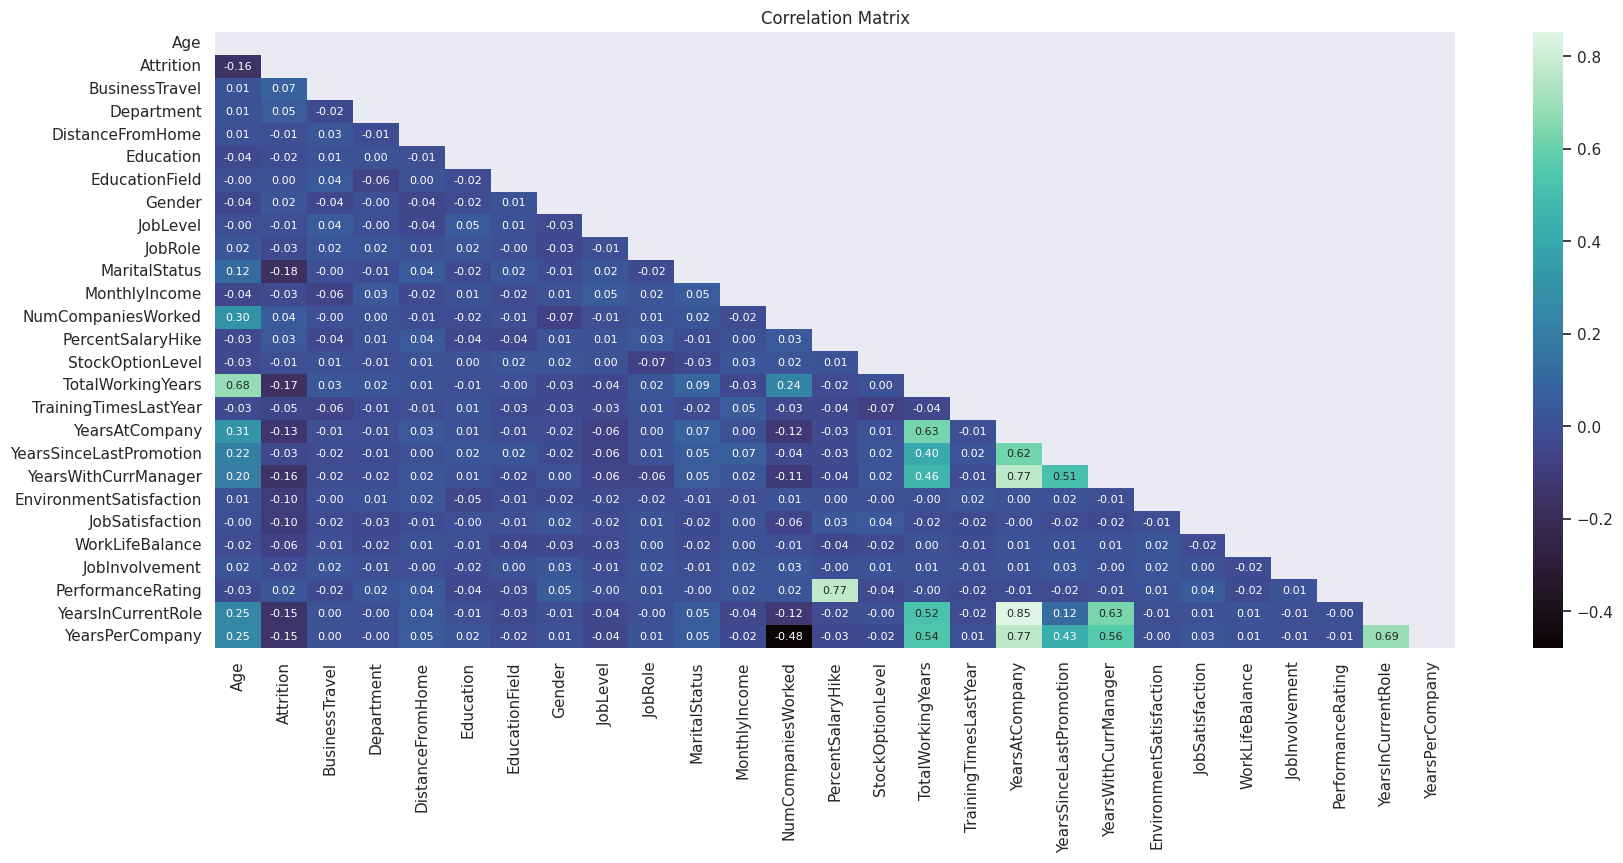

In [ ]:
sns.set(style="dark")
corr=df.corr()
fig,axes = plt.subplots(figsize=(20,8))
mask=np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,
            mask=mask,
            cmap='mako',
            annot=True,
            fmt=".2f",
            annot_kws={"size":8})
plt.title('Correlation Matrix')
plt.show()

In [ ]:
X=df.drop('Attrition', axis = 1)
y=df['Attrition']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size =0.2,
                                                    random_state = 42)



In [ ]:
classifiers = {
    "Logistic Regression" : LogisticRegression(),
    "Support Vector Classifier" : SVC(),
    "K-Nearest Neighbors" : KNeighborsClassifier(),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest Classifier" : RandomForestClassifier(),
    "XGBoost Classifier" : XGBClassifier(),
    "Extra Trees Classifier" : ExtraTreesClassifier(),
    "AdaBoost Classifier" : AdaBoostClassifier(),
    "Gradient Boosting Classifier" : GradientBoostingClassifier(),
    "Bagging Classifier" : BaggingClassifier(),
    "Histogram-based Gradient Boosting Classifier": HistGradientBoostingClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Multi-layer Perceptron" : MLPClassifier()
}

In [ ]:
classifier_names = []
accuracies = []
precisions = []
recalls = []
f1_scores_list = []

for classifier_name, classifier_instance in classifiers.items():
  clf = classifier_instance

  cv_scores = cross_val_score(clf,
                              X_train,
                              y_train,
                              cv=3,
                              scoring='accuracy')

  precision_scores = cross_val_score(clf,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring='precision')
  recall_scores = cross_val_score(clf,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring='recall')
  f1_scores = cross_val_score(clf,
                              X_train,
                              y_train,
                              cv=3,
                              scoring='f1')

  print(f"{classifier_name}:")
  print(f"Accuracy: {cv_scores.mean():.2f} with a standard deviation of {cv_scores.std():.2f}")
  print(f"Precision: {precision_scores.mean():.2f} with a standard deviation of {precision_scores.std():.2f}")
  print(f"Recall: {recall_scores.mean():.2f} with a standard deviation of {recall_scores.std():.2f}")
  print(f"F1 score: {f1_scores.mean():.2f} with a standard deviation of {f1_scores.std():.2f}")
  print("*"*50)

  classifier_names.append(classifier_name)
  accuracies.append(cv_scores.mean())
  precisions.append(precision_scores.mean())
  recalls.append(recall_scores.mean())
  f1_scores_list.append(f1_scores.mean())

metrics_df=pd.DataFrame({
    'Classifier' : classifier_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall' : recalls,
    'F1 Score' : f1_scores_list
})


Logistic Regression:
Accuracy: 0.85 with a standard deviation of 0.00
Precision: 0.72 with a standard deviation of 0.08
Recall: 0.17 with a standard deviation of 0.03
F1 score: 0.27 with a standard deviation of 0.03
**************************************************
Support Vector Classifier:
Accuracy: 0.88 with a standard deviation of 0.01
Precision: 0.86 with a standard deviation of 0.08
Recall: 0.32 with a standard deviation of 0.02
F1 score: 0.47 with a standard deviation of 0.03
**************************************************
K-Nearest Neighbors:
Accuracy: 0.84 with a standard deviation of 0.01
Precision: 0.51 with a standard deviation of 0.07
Recall: 0.27 with a standard deviation of 0.00
F1 score: 0.35 with a standard deviation of 0.02
**************************************************
Decision Tree:
Accuracy: 0.96 with a standard deviation of 0.01
Precision: 0.87 with a standard deviation of 0.06
Recall: 0.87 with a standard deviation of 0.02
F1 score: 0.86 with a standard d

In [ ]:
metrics_df.sort_values(by='Precision', ascending=False).reset_index(drop=True)

,Classifier,Accuracy,Precision,Recall,F1 Score
0,Random Forest Classifier,0.968537,0.975453,0.819298,0.890622
1,Extra Trees Classifier,0.969671,0.970852,0.819298,0.892725
2,XGBoost Classifier,0.968821,0.962086,0.840351,0.897086
3,Histogram-based Gradient Boosting Classifier,0.969671,0.956881,0.850877,0.900724
4,Bagging Classifier,0.958617,0.949134,0.782456,0.850206
5,Decision Tree,0.958617,0.867565,0.870175,0.857590
6,Multi-layer Perceptron,0.943878,0.867240,0.782456,0.821340
7,Support Vector Classifier,0.881236,0.858662,0.319298,0.465013
8,Gradient Boosting Classifier,0.882937,0.836207,0.349123,0.488123
9,Logistic Regression,0.854308,0.724253,0.170175,0.272195


In [ ]:
y_pred = RandomForestClassifier().fit(X_train, y_train).predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.99      1.00      1.00       741
           1       1.00      0.96      0.98       141

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.99       882
weighted avg       0.99      0.99      0.99       882



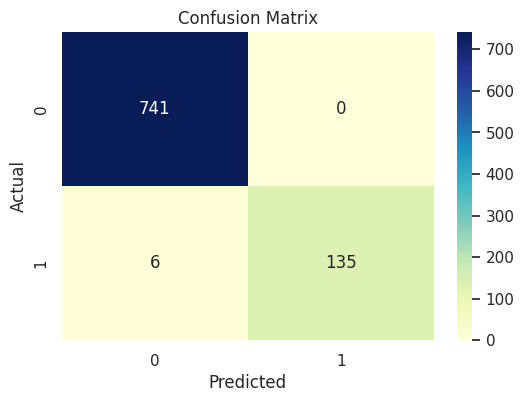

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test,y_pred),
            annot=True,
            cmap='YlGnBu',
            fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()